In [4]:
import numpy as np
import torch
from tqdm import tqdm

from bias_registry import BiasRegistry
from models.sfcn_original import SFCN

import sys
sys.path.append('..')
from utils.datasets import TorchDataset as TD
from torch.utils.data import DataLoader

In [5]:
@torch.no_grad()
def test(model, test_path, bias_idx, class_idx):
    batch_size = 8
    test_loader = DataLoader(TD(test_path), batch_size=batch_size, shuffle=False)

    model.eval()
    y_true = []
    y_pred = []

    for batch in tqdm(test_loader, desc='Test'):
        x = batch[0].to('cuda')
        y_true += 1* (batch[bias_idx]==class_idx).cpu().tolist()
        y_pred += torch.sigmoid(model(x)).detach().cpu().tolist()

    return y_true, y_pred

In [6]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_auroc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    print('AUC: ', roc_auc)

    # Create the plot
    plt.figure(figsize=(10, 8))
    plt.plot(
        fpr,
        tpr,
        color='darkorange',
        lw=2,
        label=f'ROC curve (AUC = {roc_auc:.2f})'
    )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')

    # Customize the plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    
    return roc_auc

## Trained model

Test: 100%|██████████| 42/42 [00:11<00:00,  3.78it/s]


AUC:  0.6104251644434645


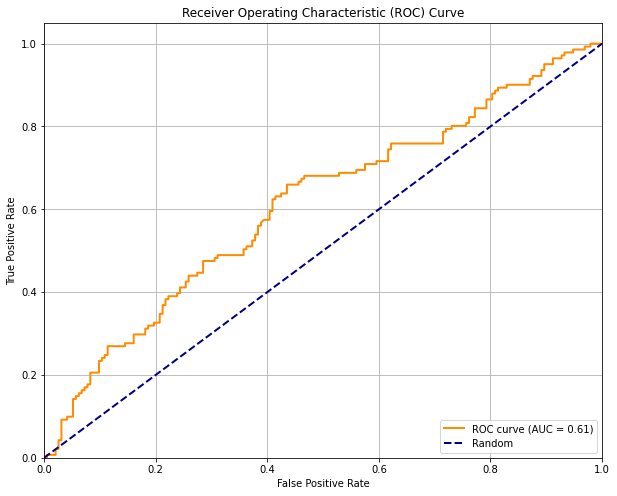

In [7]:
bias_idx = 2
class_idxs = np.arange(1)

aurocs_4 = []
    
for c in class_idxs:
    model = SFCN(output_dim=1, channel_number=[28, 58, 128, 256, 256, 64]).to('cuda')
    checkpoint = torch.load(f'checkpoints/study-Sex-{bias_idx}-{c}/best_model.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    y_true, y_pred = test(model, '/data/Data/PD/test', bias_idx, c)
    aurocs_4.append(plot_auroc_curve(y_true, y_pred))